In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import random
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In [10]:
batch_size = 32
img_height = 224
img_width = 224
NUM_CLASSES = 4
dataSeed = 1

In [4]:
DATASET_PATH = r'./Data/normalPmore'  #ใส่ path Data ที่มี Folder train, test 
Dataname = "normalPmore"  #ใส่ชื่อไว้แสดงเฉยๆ

In [5]:
import pathlib
data_dir = DATASET_PATH+r"\train"
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5378


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=dataSeed,
    image_size=(img_height, img_width),
    batch_size=batch_size,label_mode='categorical',
    shuffle = True
)

Found 5378 files belonging to 4 classes.
Using 3765 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=dataSeed,
    image_size=(img_height, img_width),
    batch_size=batch_size,label_mode='categorical',
    shuffle = True)

Found 5378 files belonging to 4 classes.
Using 1613 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['cbb', 'cbsd', 'cmd', 'healthy']


In [10]:
# model=tf.keras.applications.DenseNet121(
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     input_shape=(img_height, img_height, 3),
#     pooling=None,
#     classes=5,
#     classifier_activation="softmax",
# )

In [11]:
optimizer = "Adam"  ## ใส่ชื่อไว้แสดง

# ResNet50, DenseNet121
model_name = "ResNet50"  ## ใส่ชื่อไว้แสดง, ชื่อไฟล์โมเดล  ######################## อย่าลืมแก้
model_base=ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(img_height, img_height, 3)
) 

x=model_base.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x)
x= Dense(512,activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(NUM_CLASSES,activation='softmax')(x) #FC-layer
# model = Sequential()
# model.add(ResNet50(input_shape=(img_height,img_width,3), include_top=False, weights='imagenet'))
# model.add(GlobalAveragePooling2D())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4, activation='softmax'))

In [12]:
model=Model(inputs=model_base.input,outputs=preds)

In [13]:
for layer in model.layers[:-NUM_CLASSES]:
    layer.trainable=False
    
for layer in model.layers[-NUM_CLASSES:]:
    layer.trainable=True

In [14]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [15]:
# my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=2),
#     tf.keras.callbacks.ModelCheckpoint(filepath='/ch/model.{epoch:02d}-{val_loss:.2f}.h5'),
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
# ]

In [16]:
# learningRate = 0.0001
# anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=learningRate)
# checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [17]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()

print("now =", now)

# dd/mm/YY H:M:S
str_time = now.strftime("%Hl%Ml%S")
print("date and time =", str_time)

now = 2022-11-27 20:03:18.584703
date and time = 20l03l18


In [18]:
%%time
MinlearningRateAdj = 0.001
nb_epochs = 20
steps_per_epoch = np.ceil(len(train_ds) / batch_size)
lr = 0.0001

anne = ReduceLROnPlateau(monitor='val_accuracy', 
                         factor=0.5, 
                         patience=2, 
                         min_delta=0.001,
                         verbose=1, 
#                          min_lr=MinlearningRateAdj, 
                        
                        )
checkpoint = ModelCheckpoint(r'./ModelSave/modelBest-'+str_time+'-'+model_name+'.h5', verbose=1, save_best_only=True)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=nb_epochs,
    verbose=1,
    callbacks=[checkpoint]
#     callbacks=[anne, checkpoint]
)


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/118 [==============================] - ETA: 0s - loss: 1.9120 - accuracy: 0.3514WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001D3A7597400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

In [19]:
model.save(r'./ModelSave/modelEnd-'+str_time+'-'+model_name+'.h5')

Model = ResNet50
DataName = normalPmore
Optimizer = Adam
Epochs = 20
Image Size = 224
Batch = 32
learningRate = 0.0001


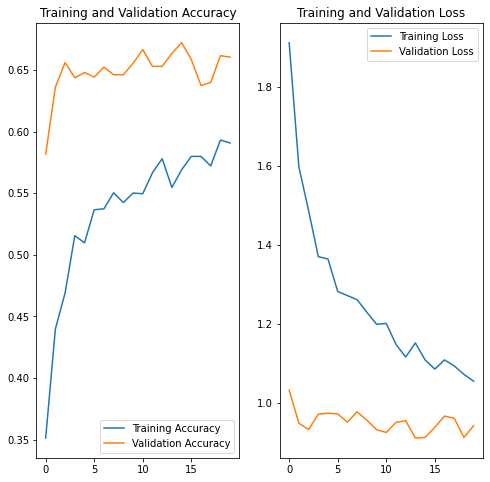

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(nb_epochs)

print("Model = "+model_name)
print("DataName = "+Dataname)
print("Optimizer = "+optimizer)
print("Epochs = {}".format(nb_epochs))
print("Image Size = {}".format(img_width))
print("Batch = {}".format(batch_size))
print("learningRate = {}".format(lr))



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

#####  use this  to save train graph as png #####################
from datetime import datetime
dt = datetime.now()
ts = datetime.timestamp(dt)
date_time = datetime.fromtimestamp(ts)
str_date_time = date_time.strftime("%d-%m-%Y_%H-%M")
graph_path = r'./experimentData/graph'
if( not (os.path.exists(graph_path)) ) :
    os.mkdir(graph_path)
plt.savefig(graph_path+'/'+str_date_time+".png")  
#####  use this  to save train graph as png #####################

plt.show()


graph_path = graph_path+'/'+str_date_time+".png"


In [26]:
model = keras.models.load_model(r"C:\Users\Chale\Desktop\AI WORK\CODE\cassava_model\GOOD MODEL\CASSAVA_MODEL.h5")

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [31]:
img_path = r"C:\Users\Chale\Desktop\AI WORK\CODE\cassava_model\ใช้ในงาน\cbb\42026505.jpg"
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to cbsd with a 26.48 percent confidence.


In [45]:
imagePaths = sorted(list(os.listdir(r"C:\Users\Chale\Desktop\AI WORK\CODE\cassava_model\ใช้ในงาน\healthy")))
for img in imagePaths:
    img_path = r"C:\Users\Chale\Desktop\AI WORK\CODE\cassava_model\ใช้ในงาน\healthy/"+img
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    #img_array = img_array/255.
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(score)
    if(np.argmax(score)==0):
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format('cbb', 100 * np.max(score))
        )
    elif(np.argmax(score)==1):
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format('cbsd', 100 * np.max(score))
        )
    elif(np.argmax(score)==2):
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format('cmd', 100 * np.max(score))
        )
    elif(np.argmax(score)==3):
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format('healthy', 100 * np.max(score))
        )

1/1 [==============================] - 0s 23ms/step
tf.Tensor([0.23436679 0.27382025 0.23605424 0.25575867], shape=(4,), dtype=float32)
This image most likely belongs to cbsd with a 27.38 percent confidence.
1/1 [==============================] - 0s 21ms/step
tf.Tensor([0.237243   0.21698762 0.19908503 0.34668437], shape=(4,), dtype=float32)
This image most likely belongs to healthy with a 34.67 percent confidence.
1/1 [==============================] - 0s 21ms/step
tf.Tensor([0.21225664 0.3618204  0.21921454 0.20670842], shape=(4,), dtype=float32)
This image most likely belongs to cbsd with a 36.18 percent confidence.
1/1 [==============================] - 0s 24ms/step
tf.Tensor([0.2579754  0.21551785 0.23289707 0.29360962], shape=(4,), dtype=float32)
This image most likely belongs to healthy with a 29.36 percent confidence.
1/1 [==============================] - 0s 41ms/step
tf.Tensor([0.28653488 0.31587753 0.19387211 0.20371541], shape=(4,), dtype=float32)
This image most likely bel

In [36]:
test_dir = r"C:\Users\Chale\Desktop\AI WORK\CODE\cassava_model\ใช้ในงาน"
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=1,
    shuffle = True
)

Found 40 files belonging to 4 classes.


In [37]:
%%time
test_data = test_ds.map(tf.autograph.experimental.do_not_convert(lambda x, y: (x , 
                                      tf.one_hot(y, depth=NUM_CLASSES))))
result = model.evaluate(test_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
40/40 [==============================] - 2s 20ms/step - loss: 1.1122 - accuracy: 0.5750
Wall time: 1.61 s


In [40]:
print(test_data)

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [39]:
test_x = []
test_y = []
for images, labels in test_data:
    test_x.append(images)
    test_y.append(np.argmax(labels))

In [14]:
%%time
preds = []
i=0;
for img in test_x:
    preds.append(np.argmax(model.predict(img, verbose=0)))
    i=i+1
    print("Running : "+str(i)+"/"+str(len(test_x))+" : "+str("{:.2f}".format(i/len(test_x)*100))+"%")
        

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Running : 1/40 : 2.50%
Running : 2/40 : 5.00%
Running : 3/40 : 7.50%
Running : 4/40 : 10.00%
Running : 5/40 : 12.50%
Running : 6/40 : 15.00%
Running : 7/40 : 17.50%
Running : 8/40 : 20.00%
Running : 9/40 : 22.50%
Running : 10/40 : 25.00%
Running : 11/40 : 27.50%
Running : 12/40 : 30.00%
Running : 13/40 : 32.50%
Running : 14/40 : 35.00%
Running : 15/40 : 37.50%
Running : 16/40

In [15]:
preds = np.array(preds)
test_y = np.array(test_y)

In [16]:
print(preds)
print(test_y)

[3 3 2 2 1 3 2 1 2 0 0 0 3 0 2 1 2 0 1 3 0 1 0 0 3 0 2 3 0 1 1 2 0 1 1 3 0
 1 3 0]
[1 1 2 2 3 3 2 2 2 1 0 0 3 0 2 3 3 0 1 1 0 3 1 1 3 1 2 3 2 0 2 2 0 1 1 3 0
 3 0 0]


In [17]:
class_names = test_ds.class_names

In [18]:
confm = tf.math.confusion_matrix(
    test_y,
    preds,
    num_classes=NUM_CLASSES,
    dtype=tf.dtypes.int32,
    name=class_names
)

In [19]:
confm = np.array(confm)

In [21]:
model_name="RESNET50"

<AxesSubplot:title={'center':'All fold confusion matrix of the multi-class classification\n\nModel RESNET50\n\nMean Accuracy is 0.57'}>

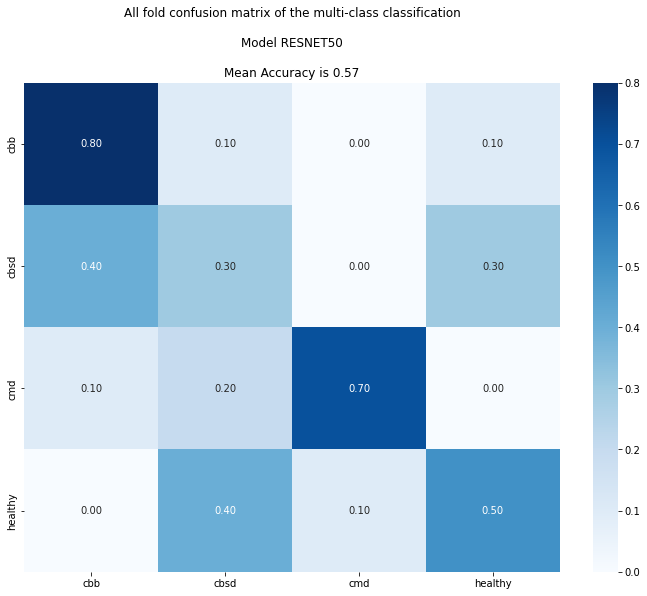

In [22]:
import seaborn as sns
import pandas as pd

df_cm = pd.DataFrame((confm/confm.astype(np.float32).sum(axis=1)), index =class_names,
              columns =class_names )
plt.figure(figsize = (12,9))
plt.title('All fold confusion matrix of the multi-class classification\n\nModel '+model_name+'\n\nMean Accuracy is {:.2f}'.format((np.mean(result[1]))))
sns.heatmap(df_cm, annot=True,cmap="Blues",fmt=".2f")

In [34]:
#model.save("./GOOD MODEL/CASSAVA_MODEL.h5")